In [172]:
# v5: change hadcrut to C&W
# v9: add constant offset method for adjusting cmip6 temps

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
import xarray as xr
import os
import glob
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import scipy.stats as stats

def make_df(path):
    all_files = glob.glob(os.path.join(path, "*.csv"))
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    return df

def get_baseline(df, t_bnds=[1850, 1900], monthly=False, multi_ens=False):
    df_hist = df[df['Experiment']=='historical']
    
    df_hist = df_hist[(df_hist['year'] > t_bnds[0]) & (df_hist['year'] < t_bnds[1])]
    
    df_hist['base_t_bnds'] = str(t_bnds[0]) + '-' + str(t_bnds[1])
    if monthly:
        df_hist = df_hist.groupby(['Model', 'base_t_bnds', 'Month']).mean().reset_index().rename(columns=baseline_name_changes)
    else:
        if multi_ens:
            df_hist = df_hist.groupby(['Model', 'Ensemble_member', 'base_t_bnds']).mean().reset_index().rename(columns=baseline_name_changes)
        else:
            df_hist = df_hist.groupby(['Model', 'base_t_bnds']).mean().reset_index().rename(columns=baseline_name_changes)
    df_hist = df_hist.drop(columns=['year'])
    return df_hist

def wmean(df, values, weights):
    return sum(df[weights]*df[values])/df[weights].sum()

def preprocess_hadcrut_z(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['Year'].between(preind_period[0], preind_period[1])]
    offset = df_pre_ind['Anomaly (deg C)'].mean()
    df_out = df[['Year', 'Anomaly (deg C)']]
    df_out['Anomaly (deg C)'] = df_out['Anomaly (deg C)'] - offset
    df_out['Anomaly (deg C)'] = df_out['Anomaly (deg C)'].rolling(window, center=True).mean()
    return df_out

def preprocess_obs(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    #df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['year'].between(preind_period[0], preind_period[1])]
    offset_w = df_pre_ind['world_tas'].mean()
    offset_na = df_pre_ind['no_arctic_tas'].mean()
    df_out = df.copy()
    df_out['world_tas'] = df_out['world_tas'] - offset_w
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'] - offset_na
    df_out['world_tas'] = df_out['world_tas'].rolling(window, center=True).mean()
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'].rolling(window, center=True).mean()
    return df_out

In [173]:
### set up and read in temp data

out_dfs = {}

## models
baseline_name_changes = {'no_arctic_tas':'no_arctic_base_tas',
                         'world_tas':'world_base_tas',
                        }
window=10

#exp='ssp370'
#exp='ssp245'
exp='ssp126'


temp_correction_method = 'scale' #options are 'scale' or 'offset'


## observations
CW_file = 'int_outputs/temperature_CW/CW_tas.csv'

Obs_df = preprocess_obs(pd.read_csv(CW_file), window=window)
obs_set = 'Cowtan & Way'


### initial processing, add baseline temp to each model, 
### only keep those models with a historic scenario available
### define one tas_df used for both plots, this contains all ensemble members

in_folder_tas = 'int_outputs/temperature_multi_ens/'

tas_df = make_df(in_folder_tas)
tas_df = tas_df[tas_df['Experiment'].isin(['historical', exp])]

tas_df = tas_df.groupby(['year', 'Experiment', 'Model', 'Ensemble_member']).mean().reset_index() 

base_tas_df = get_baseline(tas_df, [1850, 1900], multi_ens=True)

tas_df = pd.merge(tas_df, base_tas_df, how='left', on=['Model', 'Ensemble_member'])
tas_df['no_arctic_tas_anom'] = tas_df['no_arctic_tas'] - tas_df['no_arctic_base_tas']
tas_df['world_tas_anom'] = tas_df['world_tas'] - tas_df['world_base_tas']

models = tas_df[tas_df['Experiment']==exp]['Model'].unique()
tas_df = tas_df[tas_df['Model'].isin(models)]
tas_df = tas_df.dropna()

models = tas_df['Model'].unique()
print(len(models))


45


In [174]:

### define a first ensemble member version of tas_df

# this (somewhat hacky) code tries ensemble members in the order below ...
# to see what label the first member for each model has
member_labels_to_try = ['r1i1p1f1', 'r2i1p1f1', 'r1i1p2f1', 'r1i1p1f2', 'r1i2p1f1', 'r1i1p1f3', 'r4i1p1f1']

tas_df_1st_mem = tas_df[tas_df['Ensemble_member']==member_labels_to_try[0]]
for model in models:
    df_test =  tas_df_1st_mem[tas_df_1st_mem['Model']==model]
    if not exp in df_test['Experiment'].unique() or not 'historical' in df_test['Experiment'].unique():
        tas_df_1st_mem.drop(tas_df_1st_mem[tas_df_1st_mem['Model']==model].index, inplace=True)
models_1st_mem = tas_df_1st_mem['Model'].unique()
remaining_models = set(models).difference(models_1st_mem)
print(len(remaining_models))

i=1
for i in range(1,len(member_labels_to_try)):    
    df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]
    tas_df_1st_mem = pd.concat([tas_df_1st_mem, df_to_append])

    for model in models:
        df_test =  tas_df_1st_mem[tas_df_1st_mem['Model']==model]
        if not exp in df_test['Experiment'].unique() or not 'historical' in df_test['Experiment'].unique():
            tas_df_1st_mem.drop(tas_df_1st_mem[tas_df_1st_mem['Model']==model].index, inplace=True)

    models_1st_mem = tas_df_1st_mem['Model'].unique()
    remaining_models = set(models).difference(models_1st_mem)

    print(len(remaining_models))
    i=i+1
#print(remaining_models)
print(len(tas_df_1st_mem['Model'].unique()))
print(len(tas_df_1st_mem[tas_df_1st_mem['year']==1850]))

12
12
11


/tmp/ipykernel_526/4258750893.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]
/tmp/ipykernel_526/4258750893.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]
/tmp/ipykernel_526/4258750893.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]


3
3
1


/tmp/ipykernel_526/4258750893.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]
/tmp/ipykernel_526/4258750893.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]
/tmp/ipykernel_526/4258750893.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]


0
45
45


In [175]:
### drop model E3SM-1-1 as the run only goes to 2024
for model in models:
    df_test = tas_df_1st_mem[tas_df_1st_mem['Model']==model]
    #print(df_test.year.max())
    if df_test.year.max() < 2099:
        print(model)
        tas_df_1st_mem.drop(tas_df_1st_mem[tas_df_1st_mem['Model']==model].index, inplace=True)

### drop ensemble members which only have a historical run from tas_df
print(len(tas_df))
for model in models:
    for ens in tas_df[tas_df['Model']==model]['Ensemble_member'].unique():
        df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
        if not exp in df_test['Experiment'].unique():
            #print(model+ens+'  no ssp245')
            tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)
print(len(tas_df))

### check whether any ensemble members are incomplete
for model in models:
    for ens in tas_df[tas_df['Model']==model]['Ensemble_member'].unique():
        df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
        if df_test.year.max() < 2099:
            #print(model+ens + '  incomplete')
            tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)
print(len(tas_df))

## update models to represent the final list of 42
models = tas_df['Model'].unique()
print(len(models))

66251


/tmp/ipykernel_526/2274232232.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
/tmp/ipykernel_526/2274232232.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)


40062


/tmp/ipykernel_526/2274232232.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]


40062
45


In [176]:
global_warming_obs = float(Obs_df.dropna().tail(1)['world_tas'])
no_arctic_warming_obs = float(Obs_df.dropna().tail(1)['no_arctic_tas'])

obs_year = int(Obs_df.dropna().tail(1)['year'])


for temp_thresh in [1.5, 2]:

    Model = []
    No_arctic = []
    World = []
    
    M_df = pd.DataFrame(columns=tas_df_1st_mem.columns)

    blues = []
    reds = []
    years = []

    for m in models:
        #print(m)
        m_df = tas_df_1st_mem[tas_df_1st_mem['Model']==m] #use the 1st ens mem only df
        
        m_df['rolling_world_anom'] = m_df['world_tas_anom'].rolling(window, center=True).mean()
        m_df['rolling_no_arctic_anom'] = m_df['no_arctic_tas_anom'].rolling(window, center=True).mean()

        ratio_w = (m_df[m_df['year']==obs_year]['rolling_world_anom']/global_warming_obs).values[0]
        ratio_na = (m_df[m_df['year']==obs_year]['rolling_no_arctic_anom']/no_arctic_warming_obs).values[0]

        offset_w = (m_df[m_df['year']==obs_year]['rolling_world_anom'] - global_warming_obs).values[0]
        offset_na = (m_df[m_df['year']==obs_year]['rolling_no_arctic_anom'] - no_arctic_warming_obs).values[0]
        
        if temp_correction_method == 'scale':
            m_df['adjusted_world_tas_anom']= (m_df['rolling_world_anom']/ratio_w)
            m_df['adjusted_no_arctic_tas_anom']= (m_df['rolling_no_arctic_anom']/ratio_na)
        elif temp_correction_method == 'offset':
            m_df['adjusted_world_tas_anom']= (m_df['rolling_world_anom'] - offset_w)
            m_df['adjusted_no_arctic_tas_anom']= (m_df['rolling_no_arctic_anom'] - offset_na)
            
        m_df_plot = m_df[m_df['year'] >= obs_year]

        blues.append(np.array(m_df_plot['adjusted_world_tas_anom']))
        reds.append(np.array(m_df_plot['adjusted_no_arctic_tas_anom']))
        years.append(np.array(m_df_plot['year']))

    #         M_df = M_df.append(m_df, ignore_index = True) # Replaced with modern pandas below
        M_df = pd.concat([M_df,m_df],axis=0)

        #also calc crossings
        # if no crossing by 2100 (which is the case for Fgoals-g3 under ssp245) extrapolate using linregress for last 20 years
        
        no_arctic_crossing_year = np.interp(temp_thresh, m_df['adjusted_no_arctic_tas_anom'], m_df['year'])
        if np.isnan(no_arctic_crossing_year): #extrapolate
            print(m + ' doesnt cross {} without arctic'.format(temp_thresh))
            m_df_regress = m_df[m_df['year'] > 2080].dropna()
            regression = stats.linregress(m_df_regress['year'], m_df_regress['adjusted_no_arctic_tas_anom'])
            no_arctic_crossing_year = (temp_thresh - regression[1])/regression[0]
            print('extrapolated crossing year: {}'.format(str(no_arctic_crossing_year)))
            
        world_crossing_year = np.interp(temp_thresh, m_df['adjusted_world_tas_anom'], m_df['year'])

        Model.append(m)
        No_arctic.append(np.round(no_arctic_crossing_year,3))
        World.append(np.round(world_crossing_year,3))

    out_df = pd.DataFrame({'Model':Model,
                           'No_arctic_crossing_year':No_arctic,
                           'World_crossing_year':World})
    out_df['gap'] = out_df['No_arctic_crossing_year'] - out_df['World_crossing_year']
    
    out_dfs[temp_thresh] = out_df

    #mm_mean_df = out_df.groupby()

    ## add observations:
    
    print('observation year: ' + str(obs_year))
    print('{} temp in obs_year:'.format(obs_set) + str(global_warming_obs))
    print('{} temp without AA in obs_year:'.format(obs_set) + str(no_arctic_warming_obs))
    print('AA contrib:' + str((global_warming_obs-no_arctic_warming_obs)))
    print('AA contrib (%)' + str((global_warming_obs-no_arctic_warming_obs)/global_warming_obs))
    print()

FGOALS-g3 doesnt cross 1.5 without arctic
extrapolated crossing year: 2054.48326912063
IITM-ESM doesnt cross 1.5 without arctic
extrapolated crossing year: 2043.1026293481987
KIOST-ESM doesnt cross 1.5 without arctic
extrapolated crossing year: 1981.8377177389962
observation year: 2018
Cowtan & Way temp in obs_year:1.1396610170295498
Cowtan & Way temp without AA in obs_year:1.057631963059219
AA contrib:0.08202905397033078
AA contrib (%)0.07197671302659278

ACCESS-ESM1-5 doesnt cross 2 without arctic
extrapolated crossing year: 1881.854860683032
AWI-CM-1-1-MR doesnt cross 2 without arctic
extrapolated crossing year: 2041.01420830668
BCC-CSM2-MR doesnt cross 2 without arctic
extrapolated crossing year: 2064.373904795333
CAMS-CSM1-0 doesnt cross 2 without arctic
extrapolated crossing year: 2064.8779146853662
CESM2-WACCM doesnt cross 2 without arctic
extrapolated crossing year: 6525.735915503111
CIESM doesnt cross 2 without arctic
extrapolated crossing year: 596.3430531306839
CNRM-CM6-1 do

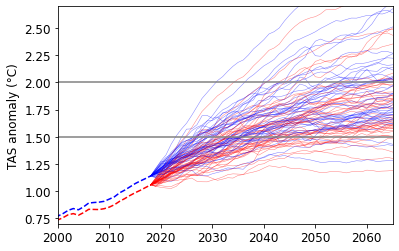

In [177]:
plt.plot(Obs_df['year'], Obs_df['world_tas'], c='blue', 
         linestyle='--', label='Observations')
plt.plot(Obs_df['year'], Obs_df['no_arctic_tas'], c='red', 
         linestyle='--', label='Observations without AA')


for i in range(len(blues)):
    plt.plot(years[i], blues[i],
             c='b', alpha=0.5, linewidth=0.5, label='CMIP6')
    plt.plot(years[i], reds[i], 
             c='r', alpha=0.5, linewidth=0.5, label='CMIP6 without AA')


plt.xlim(2000,2065)
plt.ylim(0.7, 2.7)
plt.axhline(2, color='gray')
plt.axhline(1.5, color='gray')
plt.ylabel('TAS anomaly (°C)')
plt.savefig('Figures/tas_projections.png', dpi=300)

plt.show()


In [178]:
cols_to_keep_m_df = ['year', 'Experiment', 'Model', 'adjusted_world_tas_anom', 'adjusted_no_arctic_tas_anom']
M_df = M_df[cols_to_keep_m_df]

M_df.to_csv('Outputs/master_df_temp_projections_{r}yr_rolling_{scenario}.csv'.format(r=window, scenario=exp))
Obs_df.to_csv('Outputs/Processed_{o}_{r}yr_rolling.csv'.format(o=obs_set, r=window))

mean = str(np.round(out_df['gap'].mean(), 2))
standard_error = str(np.round(out_df['gap'].sem(), 2))
print('mean gap for crossing {}C: '.format(temp_thresh)+mean+' +- '+standard_error+' years')
out_df.to_csv('Outputs/crossing_years_adjusted_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))
out_df

mean gap for crossing 2C: 188.25 +- 202.86 years


,Model,No_arctic_crossing_year,World_crossing_year,gap
0,ACCESS-CM2,2044.108,2040.328,3.780
1,ACCESS-ESM1-5,1881.855,2065.821,-183.966
2,AWI-CM-1-1-MR,2041.014,NaN,NaN
3,BCC-CSM2-MR,2064.374,NaN,NaN
4,CAMS-CSM1-0,2064.878,NaN,NaN
5,CAS-ESM2-0,2042.809,2039.802,3.007
6,CESM2,2062.936,2045.520,17.416
7,CESM2-WACCM,6525.736,2288.802,4236.934
8,CIESM,596.343,NaN,NaN
9,CMCC-CM2-SR5,2087.677,2054.088,33.589


In [179]:
#plt.plot(M_df[M_df['Model'] == 'FGOALS-g3'].dropna()['year'], 
#         M_df[M_df['Model'] == 'FGOALS-g3'].dropna()['adjusted_no_arctic_tas_anom'])
#plt.xlim(2050, 2100)
#plt.ylim(1.5, 2)
#out_dfs

In [180]:
### now repeat calc with multiple ensemble members

Model = []
Ensemble_member = []
No_arctic = []
World = []
for m in models:
    m_df = tas_df[tas_df['Model']==m]
    ens_mems = m_df[m_df['Experiment']==exp]['Ensemble_member'].unique()
    #print(m)
    for e in ens_mems:
        #print(e)
    
        me_df = m_df[m_df['Ensemble_member']==e]
        me_df.sort_values(by='year', axis=0)

        me_df['rolling_world_anom'] = me_df['world_tas_anom'].rolling(window, center=True).mean()
        me_df['rolling_no_arctic_anom'] = me_df['no_arctic_tas_anom'].rolling(window, center=True).mean()

        try:
            ratio_w = (me_df[me_df['year']==obs_year]['rolling_world_anom']/global_warming_obs).values[0]
            ratio_na = (me_df[me_df['year']==obs_year]['rolling_no_arctic_anom']/no_arctic_warming_obs).values[0]
        
            offset_w = (me_df[me_df['year']==obs_year]['rolling_world_anom'] - global_warming_obs).values[0]
            offset_na = (me_df[me_df['year']==obs_year]['rolling_no_arctic_anom'] - no_arctic_warming_obs).values[0]        
        except:
            print('error on: ' + m + e)
 
        if temp_correction_method == 'scale':
            me_df['adjusted_world_tas_anom']= (me_df['rolling_world_anom']/ratio_w)
            me_df['adjusted_no_arctic_tas_anom']= (me_df['rolling_no_arctic_anom']/ratio_na)
        elif temp_correction_method == 'offset':
            me_df['adjusted_world_tas_anom']= (me_df['rolling_world_anom'] - offset_w)
            me_df['adjusted_no_arctic_tas_anom']= (me_df['rolling_no_arctic_anom'] - offset_na) 
            
        
        no_arctic_crossing_year = np.interp(temp_thresh, me_df['adjusted_no_arctic_tas_anom'], me_df['year'])
        if np.isnan(no_arctic_crossing_year): #extrapolate
            print(m + e + ' doesnt cross {} without arctic'.format(temp_thresh))
            me_df_regress = me_df[me_df['year'] > 2080].dropna()
            regression = stats.linregress(me_df_regress['year'], me_df_regress['adjusted_no_arctic_tas_anom'])
            no_arctic_crossing_year = (temp_thresh - regression[1])/regression[0]
            print('extrapolated crossing year: {}'.format(str(no_arctic_crossing_year)))
            
        
        world_crossing_year = np.interp(temp_thresh, me_df['adjusted_world_tas_anom'], me_df['year'])
        if np.isnan(world_crossing_year): #extrapolate
            print(m + e + ' doesnt cross {}'.format(temp_thresh))
            me_df_regress = me_df[me_df['year'] > 2080].dropna()
            regression = stats.linregress(me_df_regress['year'], me_df_regress['adjusted_world_tas_anom'])
            world_crossing_year = (temp_thresh - regression[1])/regression[0]
            print('extrapolated crossing year (world): {}'.format(str(no_arctic_crossing_year)))
            
        
        Model.append(m)
        No_arctic.append(np.round(no_arctic_crossing_year,3))
        World.append(np.round(world_crossing_year,3))
        Ensemble_member.append(e)
            

out_df_ME = pd.DataFrame({'Model':Model,
                          'Ensemble_member':Ensemble_member,
                       'No_arctic_crossing_year':No_arctic,
                       'World_crossing_year':World})
out_df_ME['gap'] = out_df_ME['No_arctic_crossing_year'] - out_df_ME['World_crossing_year']

out_df_ME_all = out_df_ME.copy()
out_df_ME_all.to_csv('Outputs/Crossing_years_multi_ensemble_mems_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))
## keep only models with more than x ensemble members:
ens_members_needed = 1
models_to_keep = []
for m in models:
    n = len(out_df_ME[out_df_ME['Model']==m])
    if n >= ens_members_needed:
        models_to_keep.append(m)

out_df_ME = out_df_ME[out_df_ME['Model'].isin(models_to_keep)]

out_df_ME.to_csv('Outputs/Crossing_years_multi_ensemble_mems_for_box_plot_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))

ACCESS-ESM1-5r1i1p1f1 doesnt cross 2 without arctic
extrapolated crossing year: 1881.854860683032
ACCESS-ESM1-5r2i1p1f1 doesnt cross 2 without arctic
extrapolated crossing year: 1912.0990245070811
AWI-CM-1-1-MRr1i1p1f1 doesnt cross 2 without arctic
extrapolated crossing year: 2041.01420830668
AWI-CM-1-1-MRr1i1p1f1 doesnt cross 2
extrapolated crossing year (world): 2041.01420830668
BCC-CSM2-MRr1i1p1f1 doesnt cross 2 without arctic
extrapolated crossing year: 2064.373904795333
BCC-CSM2-MRr1i1p1f1 doesnt cross 2
extrapolated crossing year (world): 2064.373904795333
CAMS-CSM1-0r1i1p1f1 doesnt cross 2 without arctic
extrapolated crossing year: 2064.8779146853662
CAMS-CSM1-0r1i1p1f1 doesnt cross 2
extrapolated crossing year (world): 2064.8779146853662
CAMS-CSM1-0r2i1p1f1 doesnt cross 2 without arctic
extrapolated crossing year: 2053.832915083784
CAMS-CSM1-0r2i1p1f1 doesnt cross 2
extrapolated crossing year (world): 2053.832915083784
CESM2-WACCMr1i1p1f1 doesnt cross 2 without arctic
extrapola

In [181]:
len(out_df_ME.Model.unique())

45

In [182]:
models = list(set(out_df_ME['Model']))

ensemble_members = [out_df_ME[out_df_ME['Model']==model].shape[0] for model in models]

ensemble_members = [np.max(out_df_ME[out_df_ME['Model']==model]['gap']) - np.min(out_df_ME[out_df_ME['Model']==model]['gap']) for model in models]

ensemble_members = pd.DataFrame({'model':models,'members':ensemble_members})

ensemble_members = ensemble_members.sort_values('members').iloc[::-1]

35.6715777777778


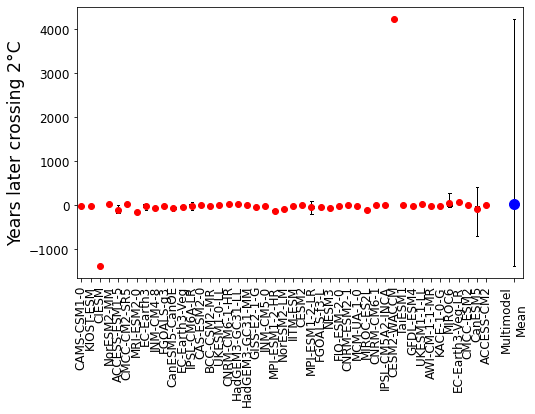

In [183]:
## plot

vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in models]
means = np.array([list(v)[0] for v in vectors])

fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.boxplot(vectors,positions=np.arange(len(vectors)),whis=[0,100],
           showmeans=True,medianprops={'linewidth':0}, vert=True,
            meanprops={'marker':'o',
              'markerfacecolor':'r',
              'markeredgecolor':'r'})

mm_shift = 2

ax.boxplot(means,positions=[len(vectors)+mm_shift],widths=0.5,
           showmeans=True,
           whis=[0,100],
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':10,
                      'markerfacecolor':'b',
                      'markeredgecolor':'b'},
          vert=True)

print(np.nanmean(means))
ax.set_xlim(-0.5,len(vectors)+mm_shift+1)
ax.set_xticklabels(list(models)+['Multimodel\nMean'],rotation=90)
ax.set_ylabel(f'Years later crossing {temp_thresh}°C',fontsize='x-large')


plt.show()

In [184]:
ordered_models = pd.DataFrame({'Model': models,
                               'Ensemble_members_count': None}).set_index('Model')
for model in ordered_models.index:
    count = len(out_df_ME[out_df_ME['Model']==model]['Ensemble_member'].unique())
    ordered_models['Ensemble_members_count'][model] = count

single_mem_models = ordered_models[ordered_models['Ensemble_members_count']==1]
multi_mem_models = ordered_models[ordered_models['Ensemble_members_count'] != 1]

#sort alphabetically for each category
single_mem_models.sort_index(inplace=True)
single_mem_models = single_mem_models[::-1]
multi_mem_models.sort_index(inplace=True)
multi_mem_models = multi_mem_models[::-1]
#recombine
ordered_models = pd.concat([multi_mem_models, single_mem_models])

#print(ordered_models)

Temp Thresh: 1.5
2038.8656666666664 2.021559427568706 2032.5275476190475 nan
gap:  6.338119047618875 +- nan
Temp Thresh: 2
2084.264577777778 107.19434536225272 2063.9068095238094 nan
gap:  20.357768253968516 +- nan


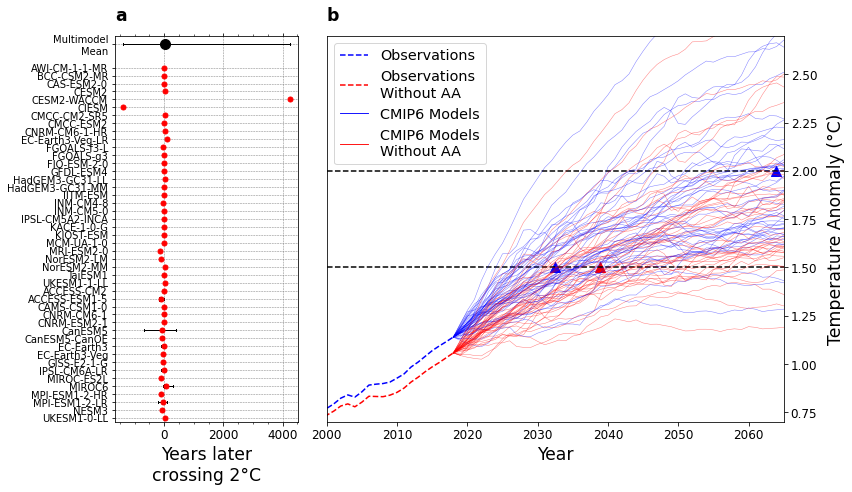

In [185]:
## combine both plots

 
#models = ensemble_members['model']
#out_df_ME.dropna(inplace=True)
vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in ordered_models.index]
means = np.array([list(v)[0] for v in vectors])
multi_mem_vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in multi_mem_models.index]
single_mem_vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in single_mem_models.index]


fig, (ax2, ax1) = plt.subplots(1,2,figsize=(12,7), gridspec_kw={'width_ratios': [1, 2.5]})
plt.rcParams['font.size'] = '12'

ax1.axhline(2, color='k',ls='--')
ax1.axhline(1.5, color='k',ls='--')
for i in range(len(blues)):
    ax1.plot(years[i], blues[i],
             c='b', alpha=0.5, linewidth=0.5)
    ax1.plot(years[i], reds[i], 
             c='r', alpha=0.5, linewidth=0.5)


## add observations:
ax1.plot(Obs_df['year'], Obs_df['world_tas'], c='blue', 
         linestyle='--', label='Observations')
ax1.plot(Obs_df['year'], Obs_df['no_arctic_tas'], c='red', 
         linestyle='--', label='Observations\nWithout AA')

# legend_without_duplicate_labels(ax1,fontsize='large')

ax1.plot([],[],lw=0.9,label='CMIP6 Models',color='b')
ax1.plot([],[],lw=0.9,label='CMIP6 Models\nWithout AA',color='r')

ax1.legend(fontsize='large')


ax1.set_xlim(2000,2065)
ax1.set_ylim(0.7, 2.7)

ax1.set_ylabel('Temperature Anomaly (°C)',fontsize='x-large', labelpad=10)
ax1.set_xlabel('Year',fontsize='x-large')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')

#ax1.yaxis.tick_left()
#ax1.yaxis.set_label_position('left')


###########################################

ax2.boxplot(vectors,positions=np.arange(len(vectors)),whis=[0,100],
           showmeans=True,medianprops={'linewidth':0}, vert=False,
            meanprops={'marker':'o', 
                       'markersize':5,
              'markerfacecolor':'r',
              'markeredgecolor':'r'})
mm_shift = 2
ax2.boxplot(means,positions=[len(vectors)+mm_shift],widths=0.5,
           showmeans=True,
           whis=[0,100],
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':10,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)


ax2.set_ylim(-0.5,len(vectors)+mm_shift+1)
ax2.set_xlabel(f'Years later\ncrossing {temp_thresh}°C',fontsize='x-large')

ax2.tick_params(axis="x",direction="out", which='both', top=True, labeltop=False, bottom=True, labelbottom=True)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax2.set_yticklabels(list(ordered_models.index)+['Multimodel\nMean'],rotation=0, fontsize='small')  

markersize=100
marker='^'
for temp_thresh in [1.5,2]:
    
    out_df = out_dfs[temp_thresh]
    
    x,y = np.nanmean(out_df['No_arctic_crossing_year']), np.nanmean(out_df['World_crossing_year'])
    z = stats.sem(out_df['gap'])
    x_e, y_e = stats.sem(out_df['No_arctic_crossing_year']), stats.sem(out_df['World_crossing_year'])
    ax1.scatter(x,temp_thresh,color='r',marker=marker,s=markersize)
    ax1.scatter(y,temp_thresh,color='b',marker=marker,s=markersize)
    
    print(f'Temp Thresh: {temp_thresh}')
    print(x, x_e, y, y_e)
    print('gap: ', x-y, '+-', z)
    

#plt.text(0, 1, 'b', fontsize='x-large', transform=ax.transAxes)
         
# fig = plt.gcf()



ax1.set_title('b', weight='bold', fontsize='x-large', loc='left', pad=15)
ax2.set_title('a', weight='bold', fontsize='x-large', loc='left', pad=15)
plt.tight_layout()

plt.savefig('Figures/Combined_{}.png'.format(exp), dpi=300)

#plt.show()

In [186]:
print(len(blues))
print(len(vectors))

45
45


In [187]:
year=2050
def ratio_of_intermodel_spread(year):
    w_e = stats.sem(M_df[M_df['year']==year]['adjusted_world_tas_anom'])
    na_e = stats.sem(M_df[M_df['year']==year]['adjusted_no_arctic_tas_anom'])
    print(w_e, na_e)
    print(((w_e-na_e)/na_e))

#for year in np.arange(2040, 2095, 1):
#    ratio_of_intermodel_spread(year)
ratio_of_intermodel_spread(year)

0.04375018664230531 0.03983794249675924
0.09820397089694896
